In [1]:
import sys
import os
import importlib

# Ajout du chemin une fois
sys.path.append(os.path.abspath('../../../python_files'))

# Liste des noms des modules à importer et recharger
module_names = [
    'preprocessing',
    'imports',
    'files',
    'clustering',
    'profile_prediction',
    'prediction_24h'
]

# Import et reload automatique
modules = {}
for name in module_names:
    modules[name] = importlib.import_module(name)
    importlib.reload(modules[name])

# Importer tout en global namespace (équivalent à from ... import *)
for name in module_names:
    exec(f'from {name} import *')


In [2]:
Simulation_Dataset = {
    "2018": "../../../data/simulated_data_7years/Mal_isole/2018/Simulation_Outputs",
    "2019": "../../../data/simulated_data_7years/Mal_isole/2019/Simulation_Outputs",
    "2020": "../../../data/simulated_data_7years/Mal_isole/2020/Simulation_Outputs",
    "2021": "../../../data/simulated_data_7years/Mal_isole/2021/Simulation_Outputs",
    "2022": "../../../data/simulated_data_7years/Mal_isole/2022/Simulation_Outputs",
    "2023": "../../../data/simulated_data_7years/Mal_isole/2023/Simulation_Outputs",
    "2024": "../../../data/simulated_data_7years/Mal_isole/2024/Simulation_Outputs"   
}

Weather_Dataset = {
    "2018": "../../../data/simulated_data_7years/Mal_isole/2018/Weather_Dataset.txt",
    "2019": "../../../data/simulated_data_7years/Mal_isole/2019/Weather_Dataset.txt",
    "2020": "../../../data/simulated_data_7years/Mal_isole/2020/Weather_Dataset.txt",
    "2021": "../../../data/simulated_data_7years/Mal_isole/2021/Weather_Dataset.txt",
    "2022": "../../../data/simulated_data_7years/Mal_isole/2022/Weather_Dataset.txt",
    "2023": "../../../data/simulated_data_7years/Mal_isole/2023/Weather_Dataset.txt",
    "2024": "../../../data/simulated_data_7years/Mal_isole/2024/Weather_Dataset.txt"   
}


In [24]:
consommation_chauffage = extract_and_concat_consommation(Simulation_Dataset, column_index=4, prefix="consommation_heat_")

# Exemple d'utilisation
city_groups = {
    "Weather_Dataset": Weather_Dataset
   
    
}

prefix_column_map = {
    "Text_": 1,
    "Hum_": 3,
    "Wind_": 4,
    "Solar_": 5,
    "Ground_": 10
}

combined_data = extract_and_combine_all(city_groups, prefix_column_map)

Text_combined = combined_data.get('Text_combined_Weather_Dataset')
occupation=pd.read_csv("../../../data/simulated_data_7years/Mal_isole/Occup_Schedule_Youssef.txt")
occ_df = pd.DataFrame(occupation["Occupancy"].values[:8760].reshape(-1, 24))
occupation_7years = pd.concat([occ_df] * 7, ignore_index=True)

In [25]:
Text_Occ_heat_profil_7years=pd.read_csv("../../../data/simulated_data_7years/result_data/profile_prediction_Text_Occupation_7years_data_from_1_novembre_to_31_avril.csv")

In [27]:
start_date = "2018-01-01"
dates = pd.date_range(start=start_date, periods=len(consommation_chauffage), freq="D") 
consommation_chauffage.insert(0, "Date", dates)

add_heating_season(consommation_chauffage)

df_conso = consommation_chauffage[consommation_chauffage["heat"] == 1].copy().reset_index(drop=True)

In [29]:
df2=pd.concat([Text_Occ_heat_profil_7years.iloc[:, :],df_conso.iloc[:, 1:-1]],axis=1).reset_index(drop=True)


In [30]:
df2['Date'] = pd.to_datetime(df2['Date'])

df2 = df2.sort_values('Date').reset_index(drop=True)

combined_rows = []

for idx, row in df2.iterrows():
    jour = row['Date']
    jour_precedent = jour - pd.Timedelta(days=1)

    prev_row = df2[df2['Date'] == jour_precedent]

    if not prev_row.empty:
        prev_row = prev_row.iloc[0]
        prev_row_renamed = prev_row.add_suffix('_j-1')
        #prev_row_renamed = prev_row_renamed.drop(['Date', 'Date_j-1'], errors='ignore')

        # Inverser l'ordre ici
        combined_row = pd.concat([prev_row_renamed.to_frame().T.reset_index(drop=True), 
                                  row.to_frame().T.reset_index(drop=True)], axis=1)

        combined_rows.append(combined_row)
    else:
        continue

df_final = pd.concat(combined_rows, ignore_index=True)
cols_to_drop = [col for col in df_final.columns if isinstance(col, str) and 'Date' in col]
df_final = df_final.drop(columns=cols_to_drop)


In [ ]:
y2= df_final.iloc[:, -24:].values 
X2 = df_final.iloc[:, :-24].values 

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X2 = scaler_X.fit_transform(X2)
y2 = scaler_y.fit_transform(y2)

X2 = X2.reshape(X2.shape[0], 1, X2.shape[1])

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, shuffle=False
)


# Vérification des dimensions
print("Shape de X_train2 :", X_train2.shape)
print("Shape de X_test2 :", X_test2.shape)
print("Shape de y_train2 :", y_train2.shape)
print("Shape de y_test2 :", y_test2.shape)

Shape de X_train2 : (1007, 1, 124)
Shape de X_test2 : (252, 1, 124)
Shape de y_train2 : (1007, 24)
Shape de y_test2 : (252, 24)


c:\Users\toubia\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0686 - mae: 0.1903 - mse: 0.0686 - val_loss: 0.0435 - val_mae: 0.1442 - val_mse: 0.0435
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0310 - mae: 0.1259 - mse: 0.0310 - val_loss: 0.0211 - val_mae: 0.1010 - val_mse: 0.0211
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0199 - mae: 0.1025 - mse: 0.0199 - val_loss: 0.0164 - val_mae: 0.0901 - val_mse: 0.0164
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142 - mae: 0.0865 - mse: 0.0142 - val_loss: 0.0144 - val_mae: 0.0831 - val_mse: 0.0144
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151 - mae: 0.0882 - mse: 0.0151 - val_loss: 0.0130 - val_mae: 0.0803 - val_mse: 0.0130
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - mae: 0.0820 - mse: 0.0130 - val_loss: 0.0120 - val_mae: 0.0750 - val_mse: 0.0120
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - mae: 0.0812 - mse: 0.0132 - val_loss:

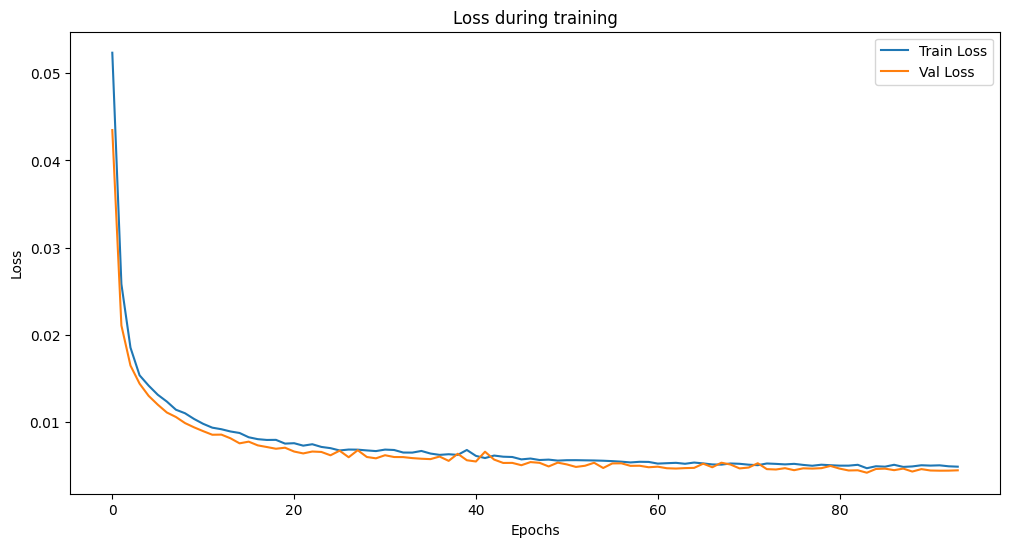

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0054 - mae: 0.0465 - mse: 0.0054
Validation Loss : 0.004142381250858307
Validation MAE: 0.03992626816034317
Validation MSE: 0.004142381250858307
Validation RMSE: 0.06436133350745855
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Test MAE: 291.2615411841936
Test MSE: 223428.164155842
Test RMSE: 472.68188473416456
Test R²: 0.8478471214217601
Test CVRMSE: 0.4321774869336795


In [32]:
model2, history2, loss2, mae2, mse2, rmse2, mae_test2, mse_test2, rmse_test2, r2, cvrmse, predictions2 = model_lstm(
    X_train2, 
    y_train2, 
    X_test2, 
    y_test2, 
    scaler_X, 
    scaler_y
)
  